<a href="https://colab.research.google.com/github/SLCFLAB/IBK2023/blob/main/06_DL_forecast_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: https://github.com/SLCFLAB/DL-Forecasting/tree/main

In [ ]:
!pip install neuralforecast statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/22

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast.core import StatsForecast
from statsforecast.models import AutoETS
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.numpy import mae

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
data_gold = pd.read_csv('https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day2/datasets/gold.csv')
data_silver = pd.read_csv('https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day2/datasets/silver.csv')

In [ ]:
def standard_scaler(data):
    mean = data['y'].mean()
    std = data['y'].std()
    data['y'] = (data['y']-mean)/std
    return mean, std, data

In [ ]:
mean_gold, std_gold, data_gold = standard_scaler(data_gold)
mean_silver, std_silver, data_silver = standard_scaler(data_silver)

In [ ]:
data = pd.concat([data_gold,data_silver])
data

,ds,y,unique_id
0,0,-1.336501,gold
1,1,-1.323519,gold
2,2,-1.260577,gold
3,3,-1.291655,gold
4,4,-1.246415,gold
...,...,...,...
1285,1285,0.951773,silver
1286,1286,0.983087,silver
1287,1287,0.920697,silver
1288,1288,0.968616,silver


In [ ]:
horizon = 1

In [ ]:
models_sf = [AutoETS()]

sf = StatsForecast(
    df = data,
    models = models_sf,
    freq = 'D',
    n_jobs = -1
)

In [ ]:
data_sf = sf.cross_validation(
    df = data,
    h = horizon,
    step_size = 1,
    n_windows = int(.1*len(data.ds.unique()))
  )

In [ ]:
data_sf = pd.read_csv('https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day2/datasets/gold_silver_ets_pretrained.csv')

In [ ]:
data_sf

,unique_id,ds,cutoff,y,AutoETS
0,gold,1161,1160,1.150495,1.107613
1,gold,1162,1161,1.153642,1.150491
2,gold,1163,1162,1.181573,1.153642
3,gold,1164,1163,1.174098,1.181570
4,gold,1165,1164,1.215010,1.174099
...,...,...,...,...,...
253,silver,1285,1284,0.951773,0.936150
254,silver,1286,1285,0.983086,0.950067
255,silver,1287,1286,0.920697,0.979485
256,silver,1288,1287,0.968616,0.927100


In [ ]:
%%capture
models_nn = [
            NHITS(h=horizon,
                  input_size=30,
                  max_steps=1000,
                  val_check_steps=100,
                  early_stop_patience_steps=3)
            ]

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
nn = NeuralForecast(models=models_nn, freq='D')

data_nn = nn.cross_validation(df=data,
                              val_size=int(.1*len(data.ds.unique())),
                              test_size=int(.1*len(data.ds.unique())),
                              n_windows=None)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
data_nn

,unique_id,ds,cutoff,NHITS,y
0,gold,1161,1160,1.127863,1.150495
1,gold,1162,1161,1.225107,1.153642
2,gold,1163,1162,1.236886,1.181573
3,gold,1164,1163,1.235458,1.174098
4,gold,1165,1164,1.225095,1.215010
...,...,...,...,...,...
253,silver,1285,1284,0.966253,0.951773
254,silver,1286,1285,1.013835,0.983087
255,silver,1287,1286,1.064236,0.920697
256,silver,1288,1287,0.990907,0.968616


In [ ]:
sf_predict = data_sf[data_sf['ds']-data_sf['cutoff']==horizon]
nn_predict = data_nn[data_nn['ds']-data_nn['cutoff']==horizon]
nn_predict

,unique_id,ds,cutoff,NHITS,y
0,gold,1161,1160,1.127863,1.150495
1,gold,1162,1161,1.225107,1.153642
2,gold,1163,1162,1.236886,1.181573
3,gold,1164,1163,1.235458,1.174098
4,gold,1165,1164,1.225095,1.215010
...,...,...,...,...,...
253,silver,1285,1284,0.966253,0.951773
254,silver,1286,1285,1.013835,0.983087
255,silver,1287,1286,1.064236,0.920697
256,silver,1288,1287,0.990907,0.968616


In [ ]:
sf_gold = sf_predict[sf_predict['unique_id']=='gold']
sf_silver = sf_predict[sf_predict['unique_id']=='silver']

nn_gold = nn_predict[nn_predict['unique_id']=='gold']
nn_silver = nn_predict[nn_predict['unique_id']=='silver']

In [ ]:
nn_gold

,unique_id,ds,cutoff,NHITS,y
0,gold,1161,1160,1.127863,1.150495
1,gold,1162,1161,1.225107,1.153642
2,gold,1163,1162,1.236886,1.181573
3,gold,1164,1163,1.235458,1.174098
4,gold,1165,1164,1.225095,1.215010
...,...,...,...,...,...
124,gold,1285,1284,1.215342,1.207929
125,gold,1286,1285,1.243107,1.216191
126,gold,1287,1286,1.268122,1.196128
127,gold,1288,1287,1.247564,1.228779


In [ ]:
sf_gold[['AutoETS','y']] = sf_gold[['AutoETS','y']]*std_gold + mean_gold
sf_silver[['AutoETS','y']] = sf_silver[['AutoETS','y']]*std_silver + mean_silver
nn_gold[['NHITS','y']] = nn_gold[['NHITS','y']]*std_gold + mean_gold
nn_silver[['NHITS','y']] = nn_silver[['NHITS','y']]*std_silver + mean_silver

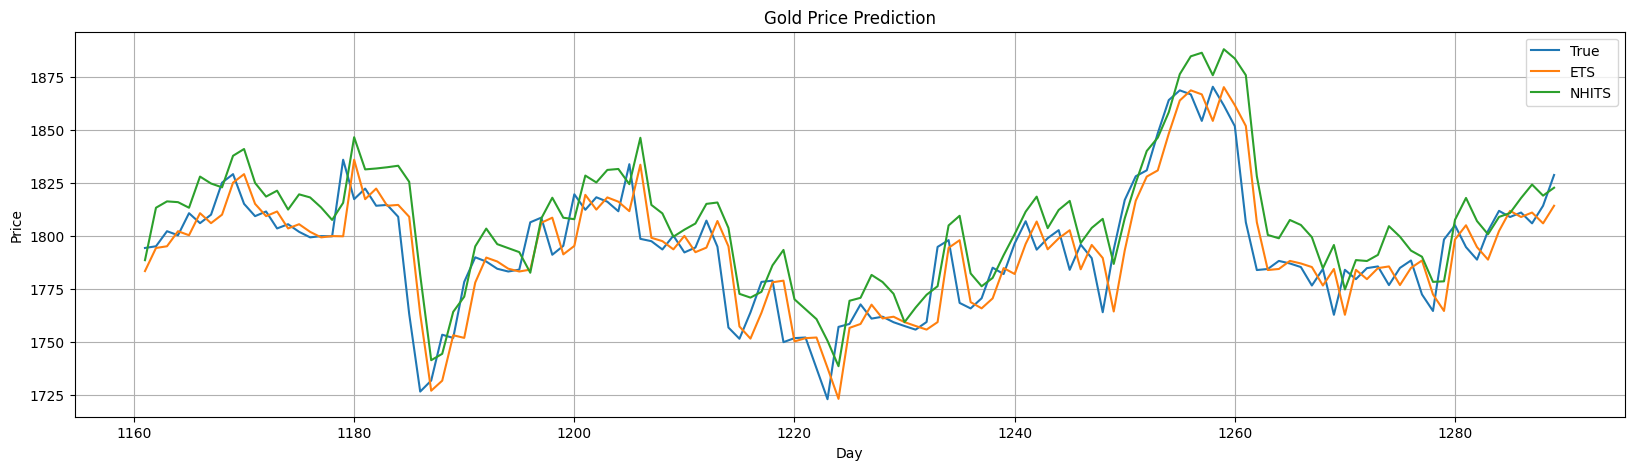

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(nn_gold['ds'], nn_gold['y'], label='True')
plt.plot(sf_gold['ds'], sf_gold['AutoETS'], label='ETS')
plt.plot(nn_gold['ds'], nn_gold['NHITS'], label='NHITS')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Gold Price Prediction')
plt.grid()
plt.legend()
plt.savefig('gold_nn_1step.png')
plt.show()

In [ ]:
mae_ets = mae(sf_gold['y'], sf_gold['AutoETS'])
mae_nhits = mae(nn_gold['y'], nn_gold['NHITS'])

print(f'ETS: {mae_ets:.3f}')
print(f'NHITS: {mae_nhits:.3f}')

ETS: 10.657
NHITS: 15.534


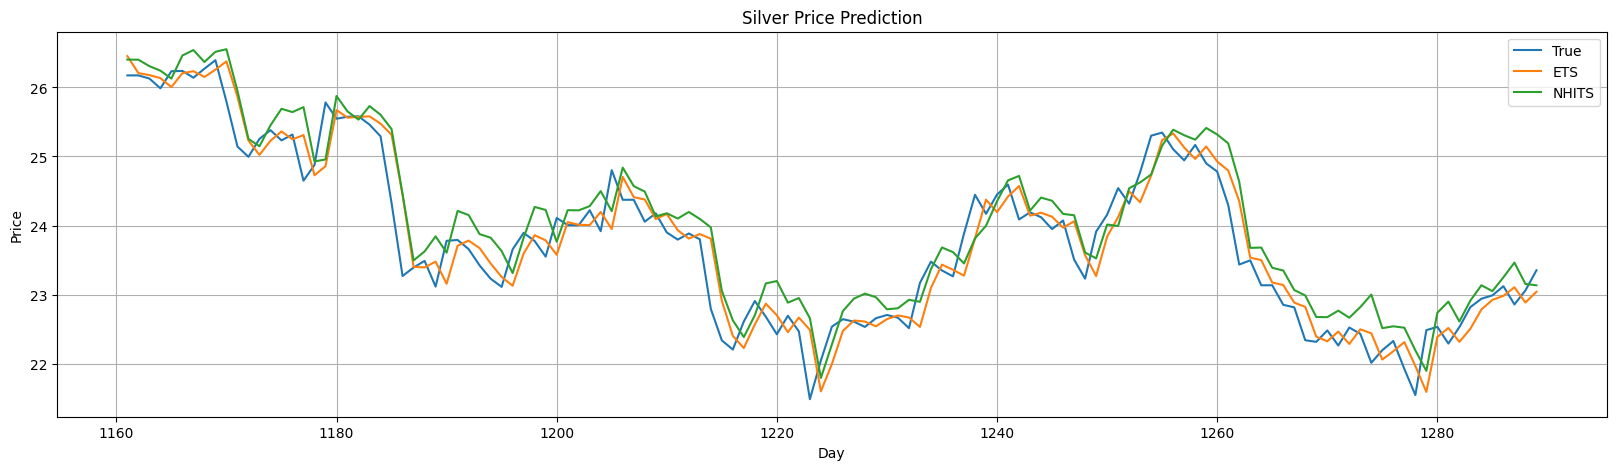

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(nn_silver['ds'], nn_silver['y'], label='True')
plt.plot(sf_silver['ds'], sf_silver['AutoETS'], label='ETS')
plt.plot(nn_silver['ds'], nn_silver['NHITS'], label='NHITS')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Silver Price Prediction')
plt.grid()
plt.legend()
plt.savefig('silver_nn_1step.png')
plt.show()

In [ ]:
mae_ets = mae(sf_silver['y'], sf_silver['AutoETS'])
mae_nhits = mae(nn_silver['y'], nn_silver['NHITS'])

print(f'ETS: {mae_ets:.3f}')
print(f'NHITS: {mae_nhits:.3f}')

ETS: 0.281
NHITS: 0.374


### Air Passengers Data
Reference: https://github.com/Nixtla/neuralforecast/blob/main/nbs/examples/Getting_Started.ipynb

In [ ]:
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


<Axes: >

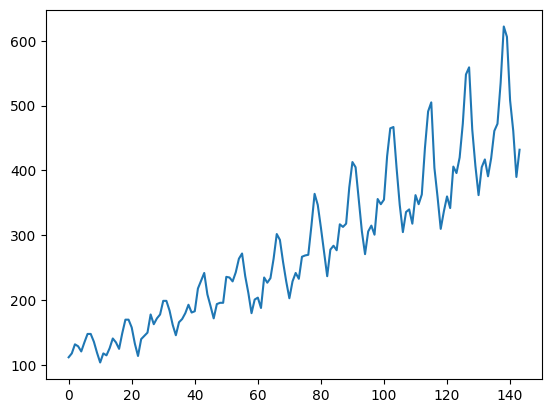

In [ ]:
Y_df['y'].plot()

In [ ]:
%%capture
horizon = 12

models_sf = [AutoETS(season_length = 12)]

sf = StatsForecast(
    df = Y_df,
    models = models_sf,
    freq = 'M',
    n_jobs = -1
)

In [ ]:
data_sf = sf.cross_validation(
    df = Y_df,
    h = horizon,
    step_size = 1,
    n_windows = 1
  )

In [ ]:
data_sf

,ds,cutoff,y,AutoETS
unique_id,,,,
1.0,1960-01-31,1959-12-31,417.0,406.651276
1.0,1960-02-29,1959-12-31,391.0,401.732910
1.0,1960-03-31,1959-12-31,419.0,456.289642
1.0,1960-04-30,1959-12-31,461.0,440.870514
1.0,1960-05-31,1959-12-31,472.0,440.333923
1.0,1960-06-30,1959-12-31,535.0,496.866058
1.0,1960-07-31,1959-12-31,622.0,545.839111
1.0,1960-08-31,1959-12-31,606.0,544.672485
1.0,1960-09-30,1959-12-31,508.0,477.034485


In [ ]:
%%capture
models_nn = [
            NHITS(h=horizon,
                  input_size=24,
                  max_steps=100,
                  val_check_steps=10,
                  early_stop_patience_steps=3)
            ]

nn = NeuralForecast(models=models_nn, freq='M')

data_nn = nn.cross_validation(df=Y_df,
                              val_size=12,
                              test_size=12,
                              n_windows=None)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
data_nn

,unique_id,ds,cutoff,NHITS,y
0,1.0,1960-01-31,1959-12-31,419.251923,417.0
1,1.0,1960-02-29,1959-12-31,432.839203,391.0
2,1.0,1960-03-31,1959-12-31,453.275909,419.0
3,1.0,1960-04-30,1959-12-31,465.137085,461.0
4,1.0,1960-05-31,1959-12-31,482.834564,472.0
5,1.0,1960-06-30,1959-12-31,553.239868,535.0
6,1.0,1960-07-31,1959-12-31,627.552734,622.0
7,1.0,1960-08-31,1959-12-31,627.370361,606.0
8,1.0,1960-09-30,1959-12-31,550.935059,508.0
9,1.0,1960-10-31,1959-12-31,462.339355,461.0


In [ ]:
Y_df[-12:]

,unique_id,ds,y
132,1.0,1960-01-31,417.0
133,1.0,1960-02-29,391.0
134,1.0,1960-03-31,419.0
135,1.0,1960-04-30,461.0
136,1.0,1960-05-31,472.0
137,1.0,1960-06-30,535.0
138,1.0,1960-07-31,622.0
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0


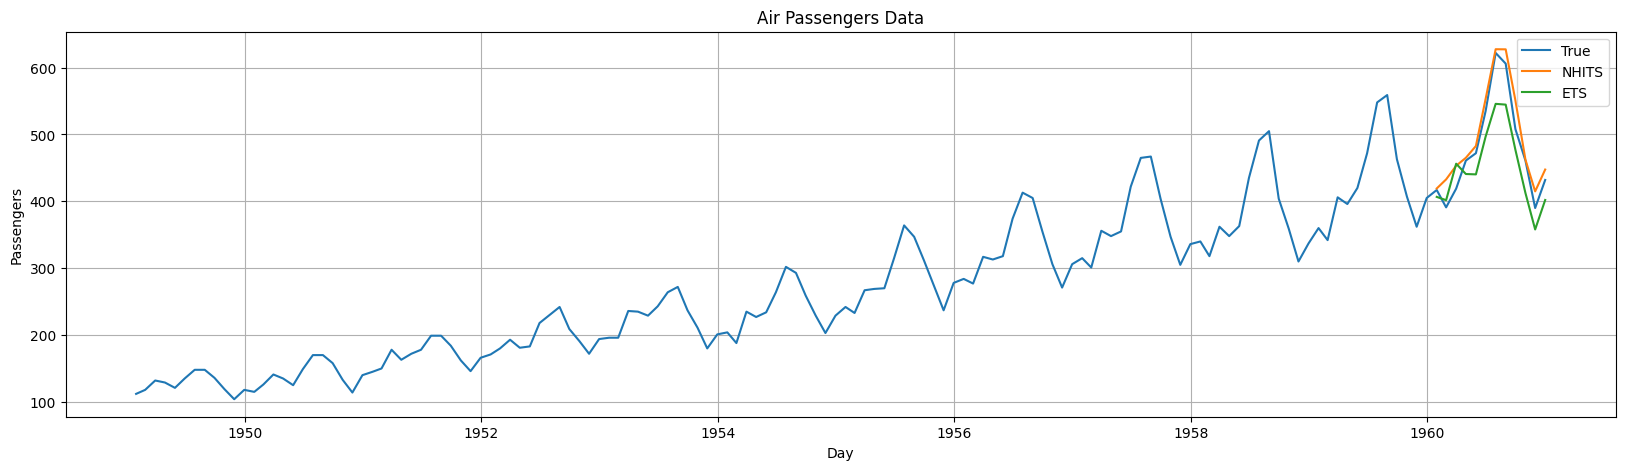

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Y_df['ds'], Y_df['y'], label='True')
plt.plot(data_nn['ds'], data_nn['NHITS'], label='NHITS')
plt.plot(data_sf['ds'], data_sf['AutoETS'], label='ETS')
plt.xlabel('Day')
plt.ylabel('Passengers')
plt.title('Air Passengers Data')
plt.grid()
plt.legend()
plt.show()